In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torch.optim as optim

import platform
from torchinfo import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from data import DESFitsDataset
from model import BinaryClassifierCNN

In [2]:
filename = '/global/cfs/cdirs/m4287/cosmology/dessn/autoscan_features.3.csv'
#filename = '/Users/bthorne/Documents/Projects/fairuniverse/autoscan_features.3.csv'
df = pd.read_csv(filename, skiprows=7, usecols=[0, 1], header=None, names=['ID', 'OBJECT_TYPE'])
labels_dict = dict(zip(df['ID'], df['OBJECT_TYPE']))

In [3]:
file_dict = {'srch': {}, 'diff': {}, 'temp': {}}
root_dir = "/global/cfs/cdirs/m4287/cosmology/dessn/stamps"
#root_dir = "/Users/bthorne/Documents/Projects/fairuniverse/home2"
#traverse_directory(root_dir, file_dict)

In [4]:
dataset = DESFitsDataset(root_dir, labels_dict)
data_loader = DataLoader(dataset, batch_size=10)

In [5]:
len(dataset)

898963

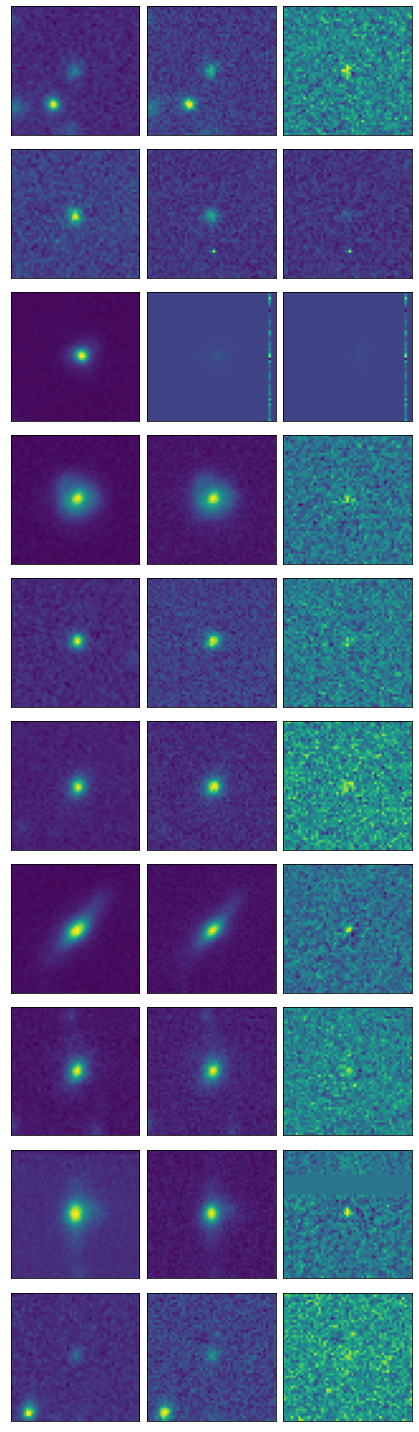

In [6]:
def plot_batch(batch):
    nbatch = batch.shape[0]
    ncols = 3
    figsize = (3 * 2, nbatch * 2)
    fig, axes = plt.subplots(nrows=nbatch, ncols=ncols, figsize=figsize)
    fig.subplots_adjust(wspace=0.05)
    for row in range(nbatch):
        for col in range(ncols):
            axes[row, col].imshow(batch[row, col, :, :])
            axes[row, col].get_xaxis().set_visible(False)
            axes[row, col].get_yaxis().set_visible(False)
    fig.tight_layout()
    return 

plot_batch(next(enumerate(data_loader))[1][0])

In [7]:
# Instantiate the model
model = BinaryClassifierCNN()
summary(model)

Layer (type:depth-idx)                   Param #
BinaryClassifierCNN                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       2,240
│    └─BatchNorm2d: 2-2                  160
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-5                       57,680
│    └─BatchNorm2d: 2-6                  160
│    └─ReLU: 2-7                         --
│    └─MaxPool2d: 2-8                    --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-9                       57,680
│    └─BatchNorm2d: 2-10                 160
│    └─ReLU: 2-11                        --
│    └─MaxPool2d: 2-12                   --
├─Flatten: 1-4                           --
├─Dropout: 1-5                           --
├─Linear: 1-6                            146,931
├─BatchNorm1d: 1-7                       102
├─Linear: 1-8                            52
Total p

In [8]:
lr = 0.001
metric = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [9]:
train_proportion = 0.5
test_proportion = 1 - train_proportion
train_size = int(train_proportion * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [10]:
# DataLoaders for train and test datasets
thin = 1
inds_train = range(0, len(train_dataset), int(1/thin))
inds_test = range(0, len(test_dataset), int(1/thin))
train_dataset = torch.utils.data.Subset(train_dataset, inds_train)
test_dataset = torch.utils.data.Subset(test_dataset, inds_test)

batch_size = 32
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=256, pin_memory=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=256, pin_memory=True)

In [11]:
if platform.system() == "Darwin":
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

Using device: cuda


BinaryClassifierCNN(
  (block1): Sequential(
    (0): Conv2d(3, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Flatten()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=2880, out_feat

In [12]:
# Training loop
num_epochs = 10
model.to(device)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_data_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = metric(outputs.squeeze(), labels.squeeze())
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_data_loader)
    print(f"Train Loss: {epoch_loss:.4f}")

    model.eval()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(test_data_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        with torch.no_grad():
            outputs = model(inputs)
            loss = metric(outputs.squeeze(), labels.squeeze())
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(test_data_loader)
    print(f"Test Loss: {epoch_loss:.4f}")

Epoch 1/10
Train Loss: 0.1707
Test Loss: 0.1472
Epoch 2/10
Train Loss: 0.1335
Test Loss: 0.1302
Epoch 3/10
Train Loss: 0.1230
Test Loss: 0.1283
Epoch 4/10
Train Loss: 0.1178
Test Loss: 0.1211
Epoch 5/10
Train Loss: 0.1139


KeyboardInterrupt: 

In [13]:
y_true = np.concatenate([labels for (_, labels) in test_data_loader])

In [ ]:
outputs = []
model.eval()
for i, (inputs, labels) in enumerate(test_data_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    with torch.no_grad():
        outputs.append(model(inputs).squeeze().detach().to("cpu").numpy())
y_score = np.concatenate(outputs)

In [ ]:
from sklearn.metrics import det_curve, auc

auc = metrics.auc(y_true, y_score)
fpr, fnr, thresholds = det_curve(y_true, y_score)

In [ ]:
goldstein = [[0.03, 0.04, 0.05], [0.037, 0.024, 0.015]]

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel("MDR")
ax.set_ylabel("FPR")
ax.plot(fpr, fnr, label="CNN")
ax.set_xlim(0, 0.1)
ax.set_ylim(0, 0.05)
ax.scatter(goldstein[0], goldstein[1], marker="s", color="k", label="Goldstein 2015")
ax.legend(loc=3, frameon=False)
fig.savefig("fpt_mdr.pdf")